# Animal Image Classification using CNN
The goal of this notebook is to train a Convolutional Neural Network in an Image classification task. This task will be the identification of 10 classes of animals being the following: [butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel].

## Imports

In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 

import os

## Constants

In [77]:
FOLDER = "Dataset/Images"

## Data Exploration

Plotting a random image to test filepaths.

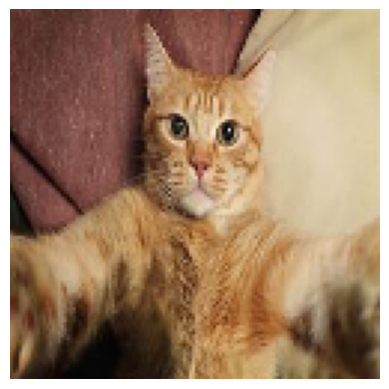

In [78]:
# plotting a random image
img = plt.imread("Dataset/images/cat/1.jpeg")
img = cv2.resize(img,(124,124))
plt.imshow(img)
plt.axis("off")
plt.show()

Count total number of images

In [79]:
#Count Number of Images
subfolders = os.listdir(FOLDER)
subfolder_lengths = [len(os.listdir(os.path.join(FOLDER, subfolder))) for subfolder in subfolders]
subfolder_lengths


[2112, 1668, 3098, 1866, 4863, 1446, 2623, 1820, 4821, 1862]

In [80]:
for i, folder in enumerate(subfolders):
    print("Folder ", folder, " lenght: ", subfolder_lengths[i])
total = sum(subfolder_lengths)
print("Total number of images: ", total)

Folder  butterfly  lenght:  2112
Folder  cat  lenght:  1668
Folder  chicken  lenght:  3098
Folder  cow  lenght:  1866
Folder  dog  lenght:  4863
Folder  elephant  lenght:  1446
Folder  horse  lenght:  2623
Folder  sheep  lenght:  1820
Folder  spider  lenght:  4821
Folder  squirrel  lenght:  1862
Total number of images:  26179


Plot on a graph to visualise distribution. We can see that the dataset is not very even with dog and spider having by far the most images. This may skew our CNN towards predicting these two classes.

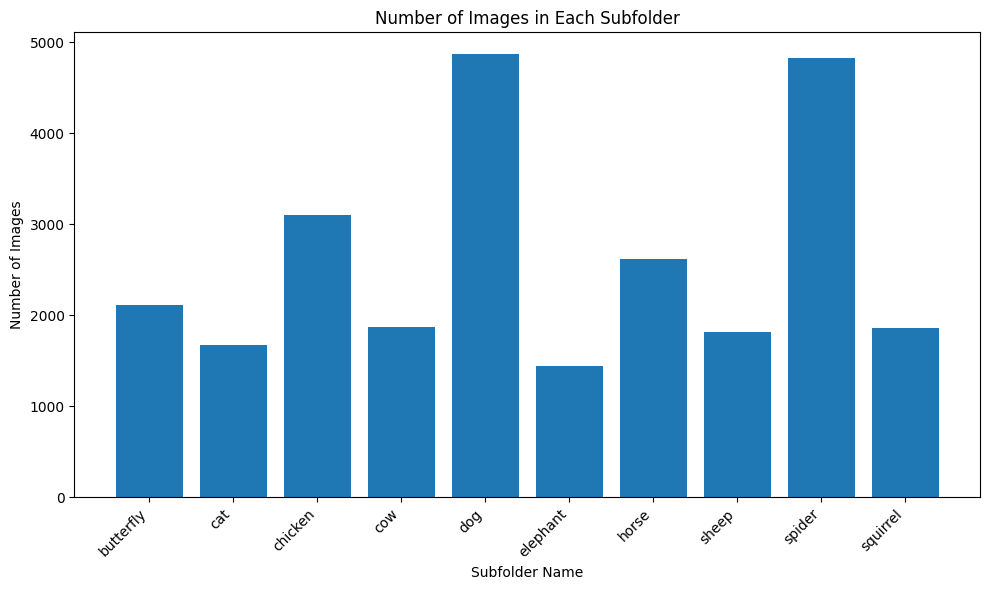

In [81]:
# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(subfolders, subfolder_lengths)
plt.xlabel('Subfolder Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Subfolder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Now code to check file types in subfolders to ensure only picture types exist.

In [82]:
# Dictionary for suffix counts
suffix_counts = {}

for folder in subfolders:
    files = os.listdir(os.path.join(FOLDER, folder))
    
    # Loop through files
    for file in files:
        # Split on dot
        suffix = file.split(".")[1]
        # Count the suffix type
        if suffix in suffix_counts:
            suffix_counts[suffix] += 1
        else:
            suffix_counts[suffix] = 1

# Print the suffix counts
for suffix, count in suffix_counts.items():
    print(f"{suffix}: {count}")     


jpg: 1919
png: 51
jpeg: 24209


Looking at the results of suffix counts, we can see that the majority of the files are of jpeg type and the dataset seems clean with only image files residing in the folders. We can move on to Data preprocessing.

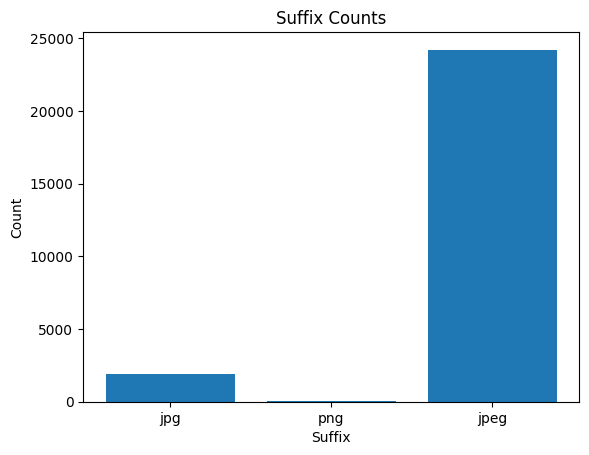

In [83]:
suffixes = list(suffix_counts.keys())
counts = list(suffix_counts.values())

# Plot the bar graph
plt.bar(suffixes, counts)

# Add labels and title
plt.xlabel('Suffix')
plt.ylabel('Count')
plt.title('Suffix Counts')

# Show the plot
plt.show()

## Data Preprocessing

Had to adapt code to work with altered dataset.
Read in images from folder and assign label to each based on folder index.
Some images had an alpha channel so further adapted code to ensure all images end up with 3 color channels.

In [91]:
x_ = list()
y = list()
IMG_SIZE = 128
sub_folders = os.listdir(FOLDER)
for folder in sub_folders:
    files = os.listdir(os.path.join(FOLDER, folder))
    path = os.path.join(FOLDER, folder)
    for img in os.listdir(path):
        try:
            file_path = os.path.join(path, img)
            # Read to array
            img_arr = cv2.imread(file_path)
            # BGR to RGB
            torgb = cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB)
            img_resize = cv2.resize(torgb,(IMG_SIZE,IMG_SIZE))
            x_.append(img_resize)
            y.append(sub_folders.index(folder)) # Labels generated from index of folder
        except:
            None


In [92]:
#convert to numpy array
x = np.array(x_)

Create a label dictionary to associate label with index

In [126]:
label_dict = {folder: index for index, folder in enumerate(sub_folders)}
label_dict

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [94]:
x.shape

(26179, 128, 128, 3)

Test how images look.

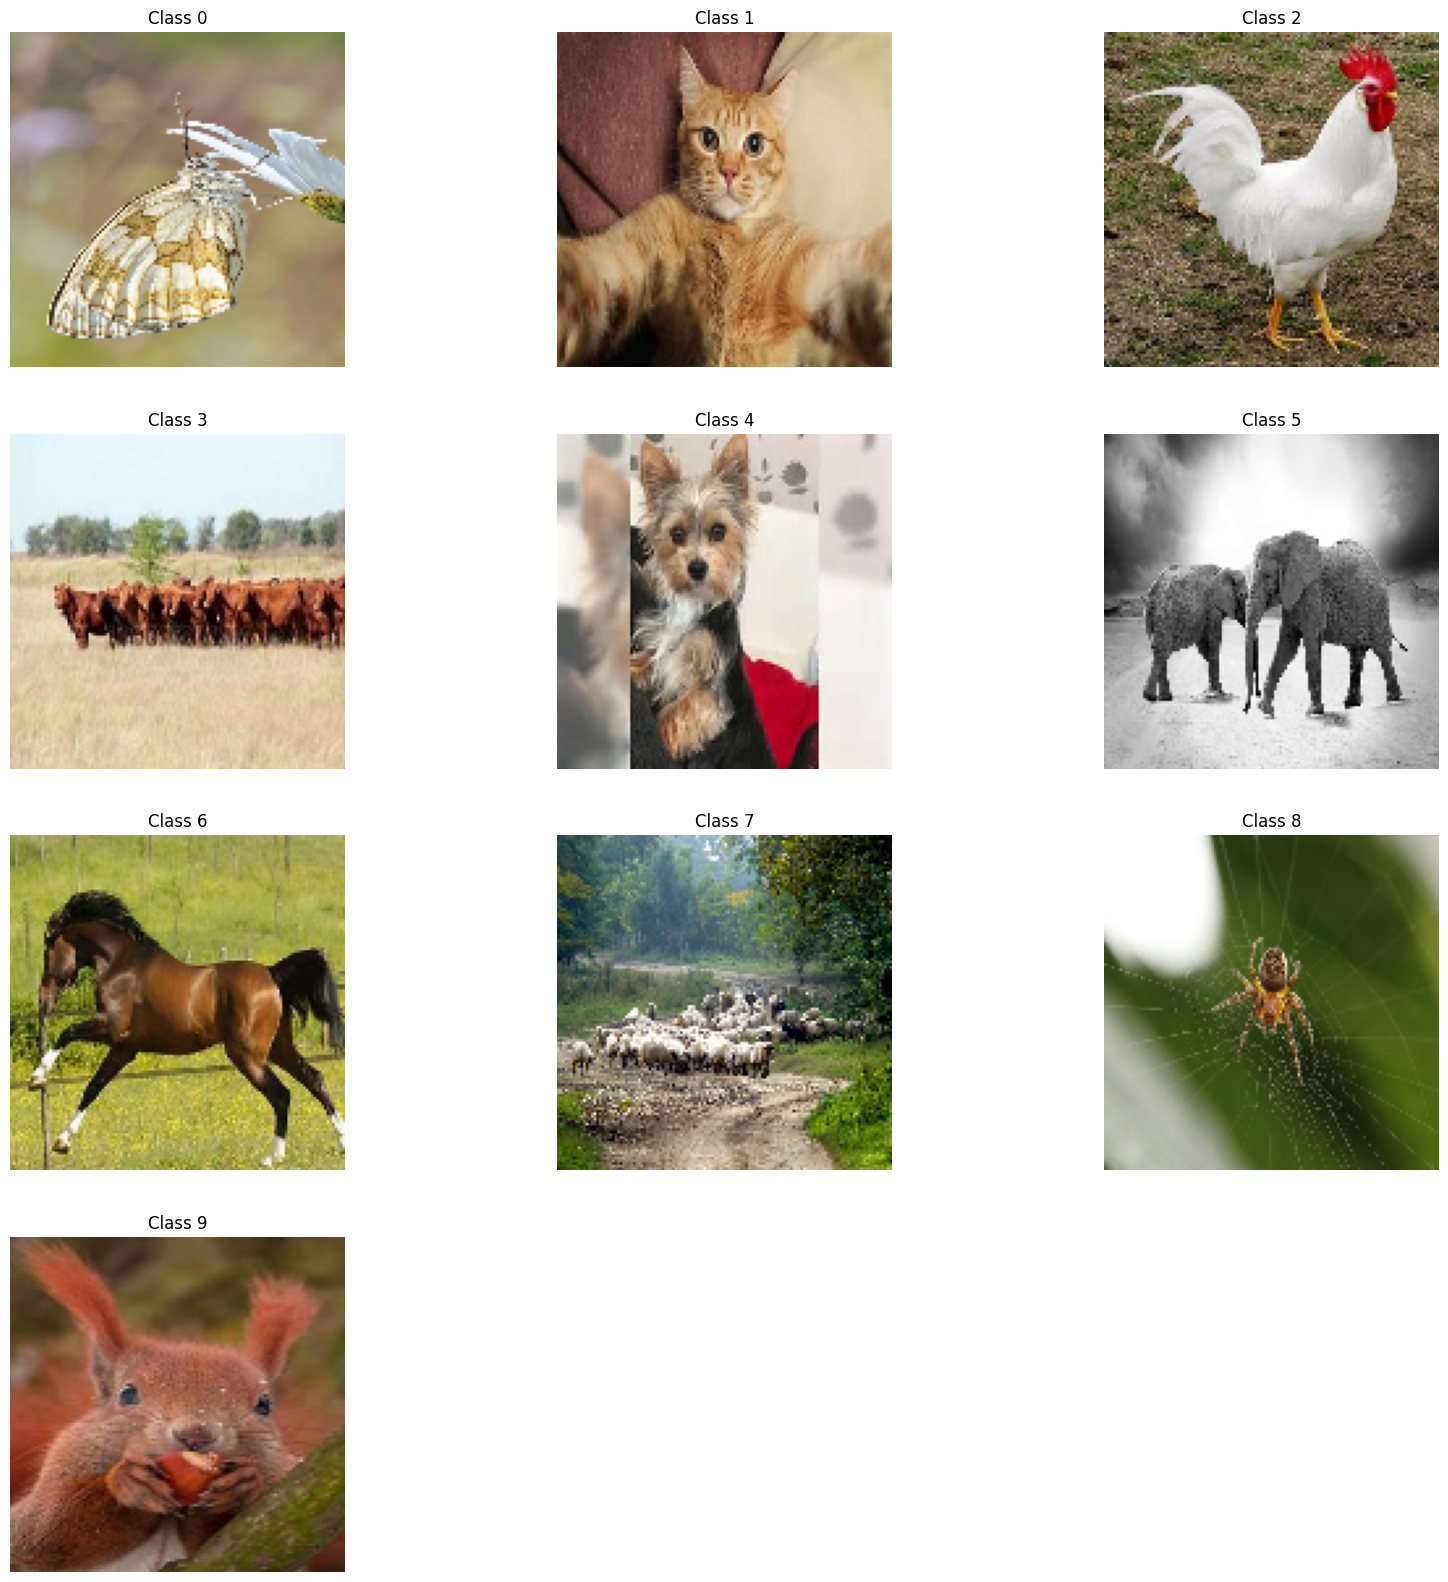

In [95]:
first_images = {}

# Loop through the images in X
for img, label in zip(x, y):
    # Check if the label already exists in the dictionary
    if label not in first_images:
        # If not, add the image to the dictionary
        first_images[label] = img

plt.figure(figsize=(20, 20))
for label in range(len(first_images)):
    img = first_images[label]
    plt.subplot(4, 3, label + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f'Class {label}')

## Data Preparation
Replace labels with types computer can understand. to_categorical uses one hot encoding to convert the labels into a binary matrix.

In [96]:
# for replacement process i'll use keras.to_categorical , keras is now part of tensorflow
from tensorflow.keras.utils import to_categorical
y = to_categorical(y,num_classes = 10)

In [97]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [98]:
y.shape

(26179, 10)

Create training and test data

In [99]:
# test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.15,random_state = 42)

Further split of test data into test and validation sets.

In [100]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.15,random_state = 42)

In [101]:
x_train.shape

(18914, 128, 128, 3)

## Model Creation

In [108]:
model = Sequential()
# 1st Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3),padding="Same",activation="relu" , input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# 2nd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# 3rd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# 4th Convolutional Layer
model.add(Conv2D(filters=256,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# 5th Convolutional Layer
model.add(Conv2D(filters=512,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# Add output layer
model.add(Dense(10,activation="softmax"))

model.summary() # print summary my model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) #compile model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 32, 32, 128)      

In [109]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [113]:
epoch = 2 
batch_size = 64

In [111]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=60,  # randomly rotate images in the range (60, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode = "reflect"
    ) 
datagen.fit(x_train)

In [114]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                              epochs= epoch,validation_data=(x_val,y_val),
                              steps_per_epoch=x_train.shape[0] // batch_size
                              )

Epoch 1/2
295/295 [==============================] - 535s 2s/step - loss: 1.6363 - accuracy: 0.4639 - val_loss: 1.4392 - val_accuracy: 0.5288
Epoch 2/2
295/295 [==============================] - 503s 2s/step - loss: 1.3860 - accuracy: 0.5371 - val_loss: 2.3409 - val_accuracy: 0.3517


In [122]:
history.history['accuracy']

[0.46392571926116943, 0.5371353030204773]

In [123]:
x_ = np.array(range(len(history.history['loss']))) # get loss values from the history
trace1 = go.Scatter(
        x = x_,
        y = history.history['loss'], # get loss values from the history
        mode = "lines",
        marker = dict(color = "rgba(0,255,0,0.9)"),
        text = "Loss"
)
trace2 = go.Scatter(
        x = x_,
        y = history.history['accuracy'],# get accuracy values from the history
        mode = "lines",
        marker = dict(color = "rgba(0,0,255,0.9)"),
        text = "Accuracy"
)
data = [trace1,trace2]
layout = dict(title = "Training Accuracy and Loss")
fig = dict(data = data,layout=layout)
iplot(fig)

105/105 [==============================] - 17s 165ms/step


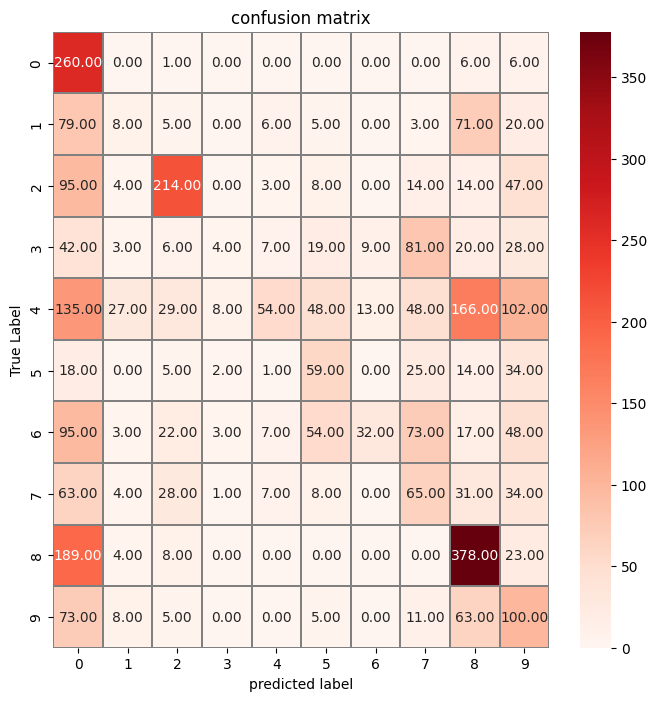

In [129]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Reds",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

### Model 2
For model two, dropout rates increased to try and prevent overfitting. Learning rate also decreased to attempt to improve model stabiliy.

In [172]:
model = Sequential()
# 1st Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3),padding="Same",activation="relu" , input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# 2nd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 3rd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# 4th Convolutional Layer
model.add(Conv2D(filters=256,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 5th Convolutional Layer
model.add(Conv2D(filters=512,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(10, activation="softmax"))

model.summary()  # Print summary of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile model


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_334 (Conv2D)         (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_345 (B  (None, 64, 64, 64)        256       
 atchNormalization)                                              
                                                                 
 dropout_63 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_335 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 32, 32, 128)     

In [173]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00075),
              metrics=['accuracy'])

Evaluating these results:
- Overall learning rate is slower which is to be expected since lr was decreased to .00075
- Overall accuracy was decreased for the second epoch, once again, expected with slower learning rate
- However, increased dropout rate seems to have worked. With less overfitting occuring and validation set accuracy increasing from first to second epoch.

In [174]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                              epochs= epoch,validation_data=(x_val,y_val),
                              steps_per_epoch=x_train.shape[0] // batch_size
                              )

Epoch 1/2
295/295 [==============================] - 478s 2s/step - loss: 2.0248 - accuracy: 0.3497 - val_loss: 1.8920 - val_accuracy: 0.4254
Epoch 2/2
295/295 [==============================] - 496s 2s/step - loss: 1.5530 - accuracy: 0.4826 - val_loss: 1.3872 - val_accuracy: 0.5431


In [176]:
x_ = np.array(range(len(history.history['loss']))) # get loss values from the history
trace1 = go.Scatter(
        x = x_,
        y = history.history['loss'], # get loss values from the history
        mode = "lines",
        marker = dict(color = "rgba(0,255,0,0.9)"),
        text = "Loss"
)
trace2 = go.Scatter(
        x = x_,
        y = history.history['accuracy'],# get accuracy values from the history
        mode = "lines",
        marker = dict(color = "rgba(0,0,255,0.9)"),
        text = "Accuracy"
)
data = [trace1,trace2]
layout = dict(title = "Training Accuracy and Loss")
fig = dict(data = data,layout=layout)
iplot(fig)

In [178]:
label_dict

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

105/105 [==============================] - 18s 167ms/step


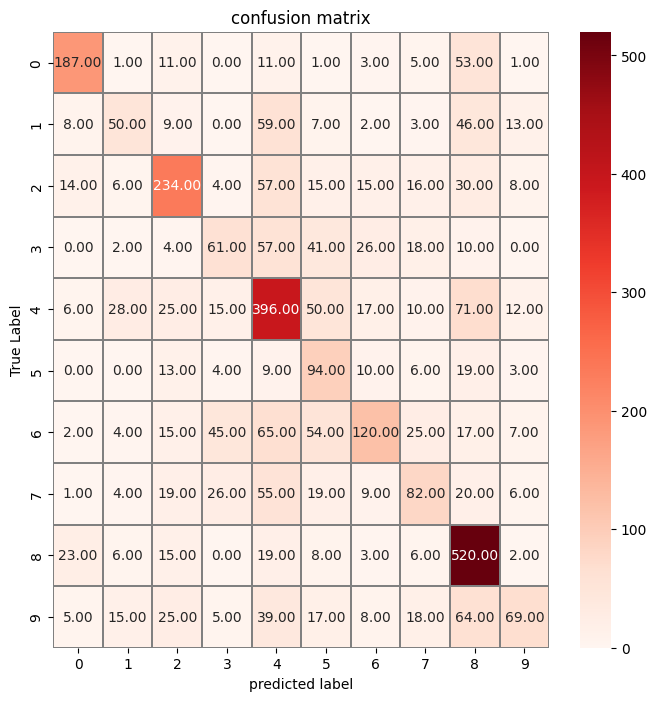

In [177]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Reds",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [179]:
value_counts = Y_pred_classes

array([4, 8, 4, ..., 5, 3, 1], dtype=int64)

### Model 3
This model will use the pretrained Inception neural network and attempt to use transfer learning to speed up training.

In [180]:
from keras.applications import InceptionV3
model2 = InceptionV3(weights='imagenet', include_top=False)

In [181]:
model2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_339 (Conv2D)         (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_351 (B  (None, None, None, 32)       96        ['conv2d_339[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, None, None, 32)       0         ['batch_normalizati

In [182]:
output_layer = model2.output
output_layer

<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'mixed10')>

In [183]:
from keras.layers import Dense, GlobalAveragePooling2D
output_layer = GlobalAveragePooling2D()(output_layer)
output_layer = Dense(1024, activation='relu')(output_layer)
predictions = Dense(10, activation='softmax')(output_layer) 

In [184]:
from keras.models import Model
model2 = Model(inputs=model2.input, outputs=predictions)

In [185]:
model2.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [188]:
history = model2.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                              epochs= epoch,validation_data=(x_val,y_val),
                              steps_per_epoch=x_train.shape[0] // batch_size
                              )

Epoch 1/2
295/295 [==============================] - 477s 2s/step - loss: 1.1263 - accuracy: 0.6436 - val_loss: 1.8879 - val_accuracy: 0.5033
Epoch 2/2
295/295 [==============================] - 521s 2s/step - loss: 0.7455 - accuracy: 0.7606 - val_loss: 1.2831 - val_accuracy: 0.6126


Evaluating these results we see that using a pretrained model in this case leads to significantly increased performance from the first Epoch as its parameters are already trained for Image classification. The model learns at a faster rate than our custom models with training loss down to .76 by only the second Epoch.
The overfitting issue does not seem to be present with validation accuracy increasing from Epoch 1 to Epoch 2.

In [189]:
x_ = np.array(range(len(history.history['loss']))) # get loss values from the history
trace1 = go.Scatter(
        x = x_,
        y = history.history['loss'], # get loss values from the history
        mode = "lines",
        marker = dict(color = "rgba(0,255,0,0.9)"),
        text = "Loss"
)
trace2 = go.Scatter(
        x = x_,
        y = history.history['accuracy'],# get accuracy values from the history
        mode = "lines",
        marker = dict(color = "rgba(0,0,255,0.9)"),
        text = "Accuracy"
)
data = [trace1,trace2]
layout = dict(title = "Training Accuracy and Loss")
fig = dict(data = data,layout=layout)
iplot(fig)

105/105 [==============================] - 16s 155ms/step


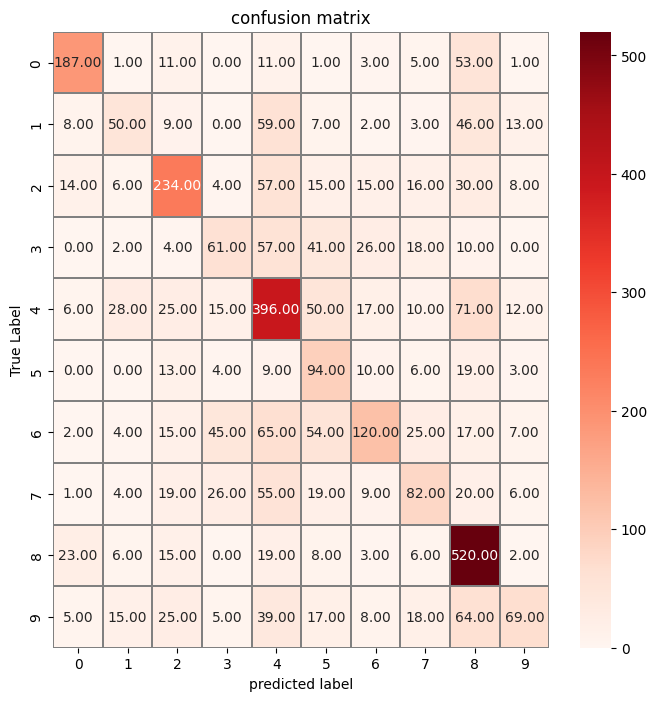

In [190]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Reds",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()